# MuhRec in python demonstration
This is a first hello world demonstration of the MuhRec python bindings.

You will:
- Load the modules
- Test a dummy reconstruction of a cylinder
- Load projection data
- Normalize the projections
- Find center of rotation
- Reconstruct some slices


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pymuhrec.utils.readers as io
import pymuhrec.utils.imageutils as amg

import pymuhrec as pm
%config InlineBackend.figure_format = 'retina'

## The muhrectomo.Reconstructor class

_muhrectomo_.Reconstructor()
> Initialize a reconstructor instance with a backprojection algorithm

_muhrectomo.Reconstructor_.name() 
> Returns the name of the current backprojector 

_muhrectomo.Reconstructor_.configure(dict(string,value))

_muhrectomo.Reconstructor_.process(array(float, 3D),dict(string, list))

_muhrectomo.Reconstructor_.matrixDims() returns the dimensions of the recunstructed matrix.

_muhrectomo.Reconstructor_.volume() Retrieves the reconstructed volume from the backprojector.

_muhrectomo_.eBackprojectors enum used by the constructor
- bpMultiProj
- bpMultiProjParallel
- bpNearestNeighbor
- bpFDKSingle
- bpFDKDouble

_muhrectomo_.eBeamGeometry enum used by the config parameter __beamgeometry__
- BeamGeometryParallel
- BeamGeometryCone
- BeamGeometryHelix
            

## Create a reconstructor object

The constructor of the Reconstruction class takes an enum to select the backprojection algorithm
- bpMultiProj
- bpMultiProjParallel (Recommended for parallel beam)
- bpNearestNeighbor
- bpFDKSingle (Recommended for cone beam)
- bpFDKDouble

In [2]:
recon = pm.Reconstructor(pm.bpMultiProjParallel)

print("Created reconstructor :",recon.name())

Created reconstructor : Multi projection BP parallel


## Reconstruction workflow

### Load data (The wood data)
The wood data is the data I use a lot for demos, tests, and tutorials. It a piece of petrified wood [DOI](http://dx.doi.org/10.17632/g5snr785xy.2). 

In [5]:
datapath = 'C:/Users/christianvedel/Imaging/NeutronImaging_test/wooddata/projections/'

#### Load projection data

In [6]:
ob = io.read_images(datapath+'ob_{0:04d}.tif',0,4,averageStack=True).mean(axis=0)
dc = io.read_images(datapath+'dc_{0:04d}.tif',0,4,averageStack=True).mean(axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
proj = io.read_images(datapath+'wood_{0:04d}.tif',0,625) # This takes a while

  0%|          | 0/626 [00:00<?, ?it/s]

In [8]:
proj.dtype

dtype('float32')

#### Inspecting the data

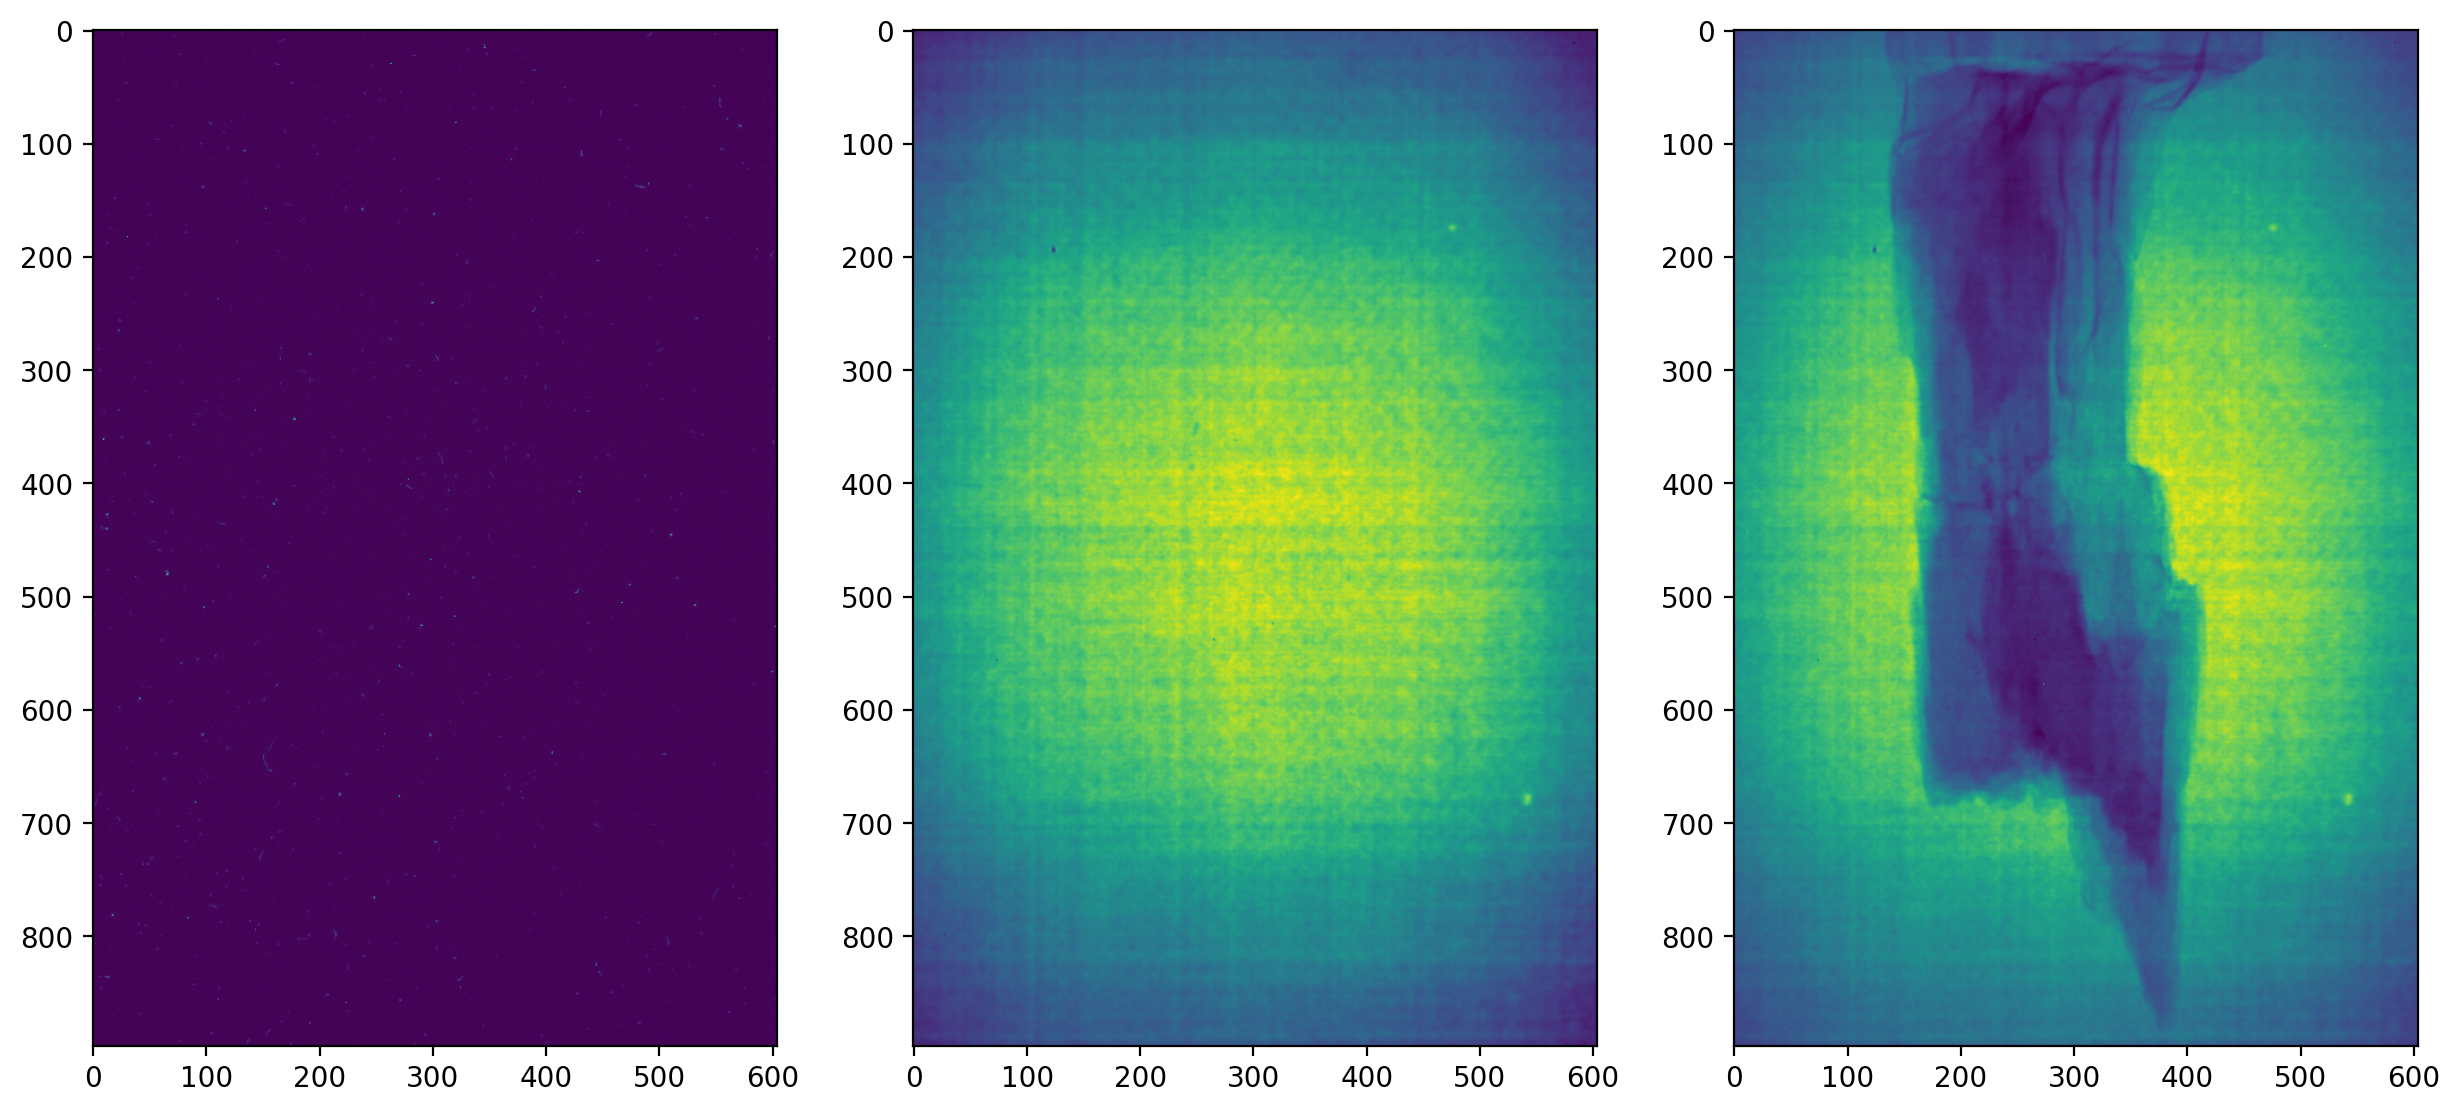

In [9]:
fig,ax = plt.subplots(1,3,figsize=[15,7])
ax[0].imshow(dc)
ax[1].imshow(ob)
ax[2].imshow(proj[0]);

## Preprocessing
Here the projections needs to be prepared for reconstruction. Typical operations are 
- Cropping
- Normalization (possibly with scattering correction)

### Normalize 
Create a image normalization instance from the imaging algorithms package. Here with short name _ia_.



In [10]:
norm = pm.NormalizeImage(True) # True for use logarithm

You can check if the logarithm is computed

In [11]:
norm.usingLog()

True

The normalization requires open beam and dark current images before processing the projections. The _ImagingAlgorithms.NormalizeImage_.process() function performs the calculation inplace. I.e., the result is stored in the in the input image.

Here, we make a deep copy of the original image for the visualization.

In [12]:
norm = pm.NormalizeImage(True) # True for use logarithm
norm.setReferences(ob,dc)
cproj = proj.copy()
norm.process(cproj)

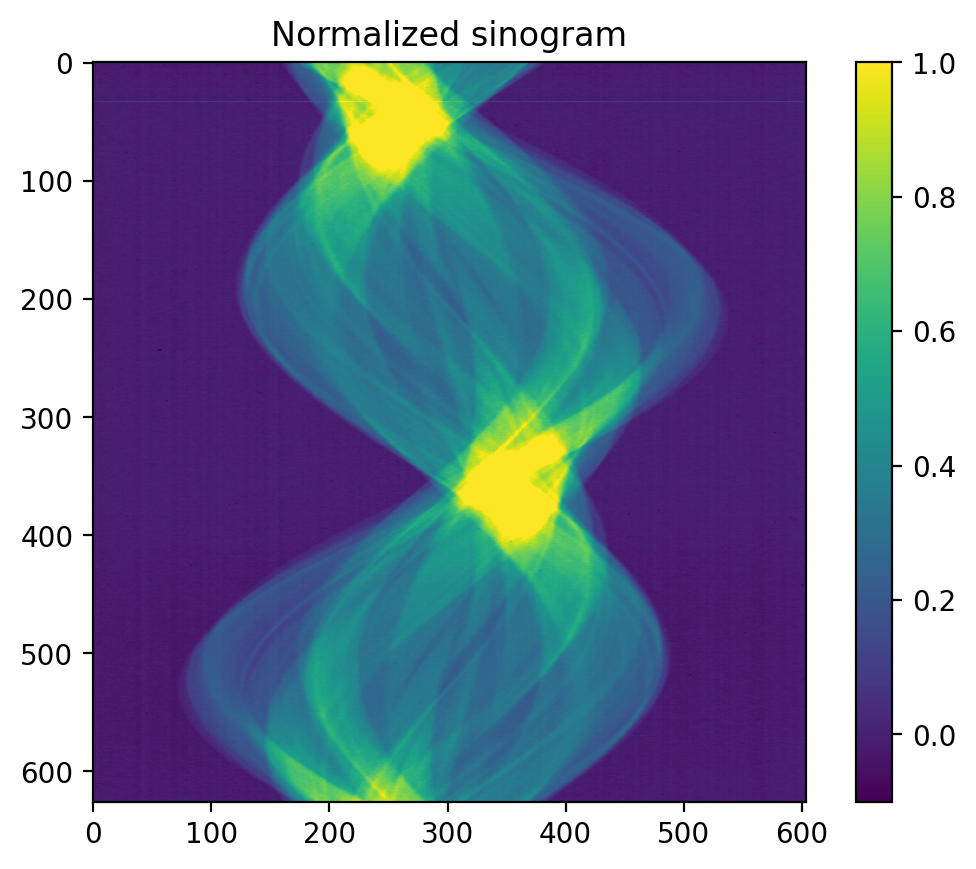

In [13]:
fig,axes=plt.subplots(1)
a0=axes.imshow(cproj[:,400,:], vmin=-0.1,vmax=1); 
axes.set_title('Normalized sinogram')
fig.colorbar(a0,ax=axes);


## Prepare and run the back-projection

### Scan geometry

__center__
> The center of rotation

__usetilt__
> Activates axis tilt correction. Valid values _True_ and _False_.

__tiltangle__
> Sets the angle of the rotation axis tilt in degrees.

__tiltpivot__
> The pivot point of the axis tilt. This is mostly in the vertical middle of the projection. The tilt is computed based on the full projection height. Therefore, it makes sense to provide the whole projection and use the __roi__ parameter.

__resolution__
> The pixel size of the projections in mm.

__roi__
> The region of interest to reconstruct. 
>
> This must be explored a bit what it actually does. the binding code must probably also be adjusted.

__direction__ 
> Sets the scan direction. Valid values are the strings "CW" for clockwise and "CCW" for counter clockwise

__beamgeometry__
> Selects the beam geometry of the scan. 
> Valid values, the strings :
> - "BeamGeometryParallel" - use this when a parallel beam is used
> - "BeamGeometryCone" - use this when a conebeam reconstructor is used
> - "BeamGeometryHelix" - this is a place holder for future implementations

#### Cone beam geometry

__sod__
> The distance from source to object in mm.

__sdd__
> The distance from source to detector in mm.

__piercingpoint__
> The coordinates in the full projection that tell where the source ray is perpendicular to the image detector plane.
>
> An array with two entries (_x_,_y_).

### Output geometry

__usematrixroi__
> A switch to select if the reconstructed matrix should be cropped. Valid values _True_ and _False_.

__matrixroi__
> The coordinates of the cropped matrix in the slice plane relative to the full slice.

__rotate__
> Rotation angle of the reconstructed matrix in degrees.

__usecircularmask__
> Switch to select if the corners should be reconstructed or masked out. 
> This region is not fully supported by the projection data and is therefore less reliable. 
> This feature can be used to explore beyond truncated projection. 



### Projection filter

__filtertype__
> Uses values from the _ImagingAlgorithms_.eProjectionFilterType enum to select projection filter
> - ProjectionFilterNone
> - ProjectionFilterRamLak
> - ProjectionFilterSheppLogan
> - ProjectionFilterHanning
> - ProjectionFilterHamming
> - ProjectionFilterButterworth, the Butterworth filter needs the __order__ parameter set to a non-zero integer value.
> - ProjectionFilterParzen

__cutoff__
> The cut-off frequency for the filter. Valid values are in the interval [0, 0.5].

__order__
> The exponent of the Butterworth filter

__usebias__
> Use a bias for the DC component of the FFT in the projection filter. This brings the value of the void closer to zero.

__biasweight__
> A weight that multiplies with the filter weight closest to the DC component to use as filter bias of the DC component.

__paddingdoubler__
> Zero padding is used to fill the projection vector to the next $2^N$. The padding doubler _M_ extends the padding to $2^{N+M}$.

### Threading
__maxthreads__
> Set the maximum number of threads to use. <br/> Default is -1, which sets threads to number of cores.

## Finding the center of rotation
The class _imagingalgorithms_.TomoCenter can be used to find the center of rotation. 

_imagingalgorithms.TomoCenter_.estimate(p0,p180,centerMethod,bool) 

returns an array with the values [center, tilt, pivot]

In [15]:
ce = pm.TomoCenter()

center=ce.estimate(cproj[0,500:700,:],cproj[312,500:700:,:],pm.centerLeastSquare,False)

The tilt correction is still based on the provided projections and will not be correct if you use a different number of projections.

In [21]:
# Geometry information
recon.configure({   "center"     : center[0],
                    "usetilt"    : False,
                    "tiltangle"  : -center[1],
                    "tiltpivot"  : center[2],
                    "resolution" : 0.01
                })

In [22]:
Nproj = cproj.shape[0]
# Information per projection
args = {"angles"  : np.linspace(0,360,num=Nproj), 
        "weights" : np.ones(Nproj)/Nproj
       }


print("Have",Nproj,"projections")

recon.process(cproj[:,500:700,:].astype('float64'),args) # Reconstruct a part of the slices (32 slices here)
if 'vol' in globals():
    del vol
vol = recon.volume() # Retrieve the reconstructed volume

Have 626 projections
604 200 626


In [23]:
ce = pm.TomoCenter()

center=ce.estimate(cproj[0,500:700,:],cproj[312,500:700:,:],pm.centerLeastSquare,True)

In [24]:
# Geometry information
recon.configure({   "center"     : center[0],
                    "usetilt"    : True,
                    "tiltangle"  : -center[1],
                    "tiltpivot"  : center[2],
                    "resolution" : 0.01
                })

In [25]:
Nproj = cproj.shape[0]
# Information per projection
args = {"angles"  : np.linspace(0,360,num=Nproj), 
        "weights" : np.ones(Nproj)/Nproj
       }


print("have",Nproj,"projections")

recon.process(cproj[:,500:700,:].astype('float64'),args) # Reconstruct a part of the slices (32 slices here)
if 'vol2' in globals():
    del vol2
vol2 = recon.volume() # Retrieve the reconstructed volume

have 626 projections
604 200 626


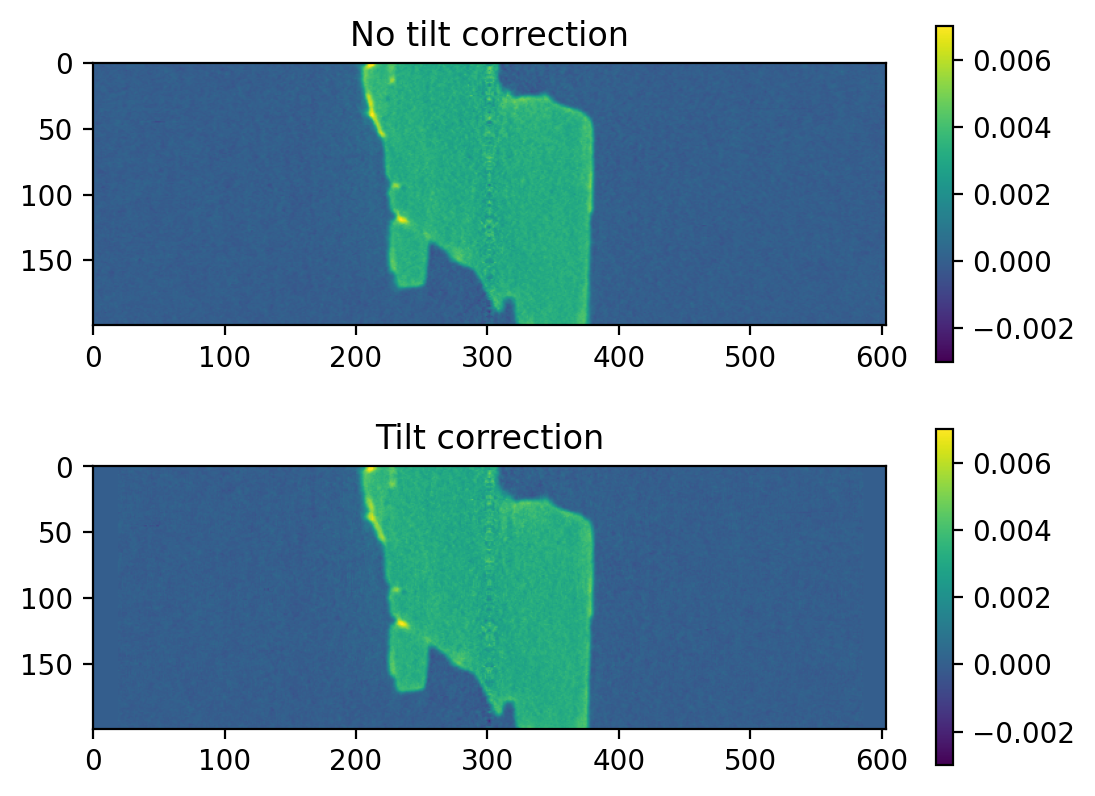

In [26]:
fig,ax = plt.subplots(2,1)

vmin = -0.003
vmax = 0.007
a=ax[0].imshow(vol[:,:,300],vmin=vmin,vmax=vmax)
ax[0].set_title("No tilt correction")
fig.colorbar(a,ax=ax[0])

a=ax[1].imshow(vol2[:,:,300],vmin=vmin,vmax=vmax)
fig.colorbar(a,ax=ax[1])
ax[1].set_title("Tilt correction")

plt.savefig('recon.png',dpi=300)

__Note__: There is a bug in the tilt correction that accumulates the noise [Github issue 596](https://github.com/neutronimaging/imagingsuite/issues/596).

In [27]:
vol.shape

(200, 604, 604)

## Next steps

- [ ] Check resolution parameter
- [ ] Check how weights are used

4.6875